# Capstone Project - The Battle of the Neighbourhoods

## Introduction: Business Problem

In this project we will try to find an optimal location for a bakery in/around Downtown Toronto, Canada.

Because of the trendiness of bakeries in Toronto we will try to detect locations that are not already crowded with bakeries but yet as close to city centre as possible.

Based on these criteria, we will use our data science prowess to generate a few promising streets and spots. Advantages of each area will then be clearly expressed for the purposes of finding the best possible final location which can be chosen by stakeholders.

## Data

Based on our problem as defined above, factors that will influence our decision are:

    - number of existing bakeries in/around the downtown area;
    - number of existing substitute places – bagel shops, delis, etc.;
    - distance to bakeries in the downtown area, if any distance from city centre;
    - distance to sightseeings/crowded venues.

The number of bakeries and their type and location as well as sightseeings in and around Downtown Toronto will be obtained using Foursquare API.

## Methodology

In this section we will perform some data analysis to get insights. Clustering of all bakeries, substitutes and sightseeings will help us locate a new bakery.

    

### Data

In [2]:
# import libraries
import numpy as np  
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [4]:
# credentials
CLIENT_ID = 'NXBH3YZOFDJTYKSQ0CX5LOPGVW4UPTYY4FDSDWV3HBA05D3T'
CLIENT_SECRET = 'L0VQNUBLXK4A401TJ0G2TX3MIWNXZ2RCXICZATJED14B1S1M'

latitude='43.651070'
longitude='-79.347015'
VERSION='20180323'
query='bagel,bakery'
categoryid='4bf58dd8d48988d16a941735,4bf58dd8d48988d179941735,4bf58dd8d48988d143941735, 4bf58dd8d48988d143941735, 4bf58dd8d48988d1bc941735, 4bf58dd8d48988d148941735',
neighborhood='postalCode'
radius=4000
limit=200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NXBH3YZOFDJTYKSQ0CX5LOPGVW4UPTYY4FDSDWV3HBA05D3T
CLIENT_SECRET:L0VQNUBLXK4A401TJ0G2TX3MIWNXZ2RCXICZATJED14B1S1M


In [5]:
# search for bakeries and substitutes
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='CLIENT_ID',
client_secret='CLIENT_SECRET',
v='20180323',
ll='43.651070,-79.347015',
query='bagel,bakery',
categoryid='4bf58dd8d48988d16a941735,4bf58dd8d48988d179941735,4bf58dd8d48988d143941735, 4bf58dd8d48988d143941735, 4bf58dd8d48988d1bc941735, 4bf58dd8d48988d148941735',
limit=200,
radius=4000)
url_bakery = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&categoryid={}&postalCode={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,query,categoryid, neighborhood, radius, limit)
results_bakery = requests.get(url_bakery).json()

# assign relevant part of JSON to venues
venues_bakery = results_bakery['response']['venues']

# examine results
df_bakery=json_normalize(venues_bakery)
print("There are {} bakeries in Toronto".format(df_bakery.shape[0]))

There are 49 bakeries in Toronto


In [6]:
# find information of interest and filter dataframe

filtered_columns = ['name', 'categories'] +[col for col in df_bakery.columns if col.startswith('location.')] + ['id']
df_filtered = df_bakery.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
    except:
            address = None
            postal_code = None
            district = None
            df_filtered.append([postal_code])
    
# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]


#dataframe_filtered
bakeries_df=df_filtered[['name','categories','address','distance','lat','lng','neighborhood','postalCode','id']]
bakeries_df.reset_index(inplace=True)
bakeries_df.head(100)

,index,name,categories,address,distance,lat,lng,neighborhood,postalCode,id
0,0,Brick Street Bakery,Bakery,27 Trinity St,1010,43.650574,-79.359539,NaN,M5A 3C4,4b156a02f964a5207fac23e3
1,1,The Bagel Stop,Bagel Shop,161 Bay St.,2639,43.646184,-79.379077,Financial District,NaN,4d3872479784a0931e57e0e8
2,2,Bagel Stop,Bagel Shop,Ernst & Young Tower,2724,43.647931,-79.380564,NaN,M5L 1L5,4d36edee10248cfa02d889cf
3,3,The Bagel Stop,Bagel Shop,20 Bay St,2670,43.641619,-79.377486,NaN,M5J 2N8,4b910b08f964a5208fa033e3
4,4,Bakery And Deli,Deli / Bodega,NaN,907,43.659127,-79.348743,NaN,NaN,522f966011d221423d1d71c8
5,5,Bagel Stop,Bagel Shop,199 Bay St (Commerce Court),2603,43.648324,-79.379110,NaN,M5L 1G5,52e11a21498e7356498a1d7d
6,6,Bagel Stop Express,None,2018 Queen Street East,2589,43.664621,-79.320873,NaN,NaN,4bb664ff2ea19521439aab2f
7,7,What A Bagel,Breakfast Spot,130 Spadina Ave,3960,43.647349,-79.395912,NaN,NaN,4f7dd9a6e4b09d309a47f7fe
8,8,Bagel Time,Breakfast Spot,415 Yonge Street,2987,43.659642,-79.382171,NaN,M5B 2E7,4b7c0070f964a520e3772fe3
9,9,Bagel Stop,Bagel Shop,121 King Street,2824,43.647820,-79.381788,NaN,NaN,550c4713498e1e886da1d169


In [7]:
# rename columns
bakeries_df.rename(columns = {'postalCode':'postal code','lat':'latitude','lng':'longitude'}, inplace = True)
# drop the office from the categories with 'bakery' in the name
bakeries_df=bakeries_df.drop(bakeries_df[bakeries_df.categories=='Office'].index)
bakeries_df.head(50)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,index,name,categories,address,distance,latitude,longitude,neighborhood,postal code,id
0,0,Brick Street Bakery,Bakery,27 Trinity St,1010,43.650574,-79.359539,NaN,M5A 3C4,4b156a02f964a5207fac23e3
1,1,The Bagel Stop,Bagel Shop,161 Bay St.,2639,43.646184,-79.379077,Financial District,NaN,4d3872479784a0931e57e0e8
2,2,Bagel Stop,Bagel Shop,Ernst & Young Tower,2724,43.647931,-79.380564,NaN,M5L 1L5,4d36edee10248cfa02d889cf
3,3,The Bagel Stop,Bagel Shop,20 Bay St,2670,43.641619,-79.377486,NaN,M5J 2N8,4b910b08f964a5208fa033e3
4,4,Bakery And Deli,Deli / Bodega,NaN,907,43.659127,-79.348743,NaN,NaN,522f966011d221423d1d71c8
5,5,Bagel Stop,Bagel Shop,199 Bay St (Commerce Court),2603,43.648324,-79.379110,NaN,M5L 1G5,52e11a21498e7356498a1d7d
6,6,Bagel Stop Express,None,2018 Queen Street East,2589,43.664621,-79.320873,NaN,NaN,4bb664ff2ea19521439aab2f
7,7,What A Bagel,Breakfast Spot,130 Spadina Ave,3960,43.647349,-79.395912,NaN,NaN,4f7dd9a6e4b09d309a47f7fe
8,8,Bagel Time,Breakfast Spot,415 Yonge Street,2987,43.659642,-79.382171,NaN,M5B 2E7,4b7c0070f964a520e3772fe3
9,9,Bagel Stop,Bagel Shop,121 King Street,2824,43.647820,-79.381788,NaN,NaN,550c4713498e1e886da1d169


In [9]:
# locate bakeries and substitutes
bakerymap= folium.Map(location=[43.651070,-79.347015], zoom_start=12) 

folium.features.CircleMarker(
    [43.651070,-79.347015],
    radius=3000,
    popup='Toronto',
    fill_opacity = 0.6
).add_to(bakerymap)

# add markers to represent bakeries and substitutes 
for lat,lng,name,categories in zip(bakeries_df['latitude'],bakeries_df['longitude'],bakeries_df['name'],bakeries_df['categories']):
    label = folium.Popup(str(name), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill = True,
        fill_opacity=0.6,
        parse_html=False
    ).add_to(bakerymap)

# display map
bakerymap


### Methodology
Finding distance between bakeries, Downtown Toronto and sightseeings will provide guidelines about the proper area for a new bakery.

NameError: name 'plot' is not defined

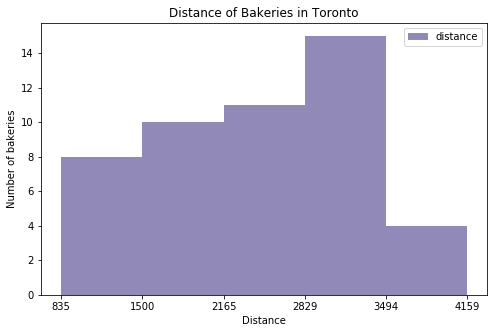

In [11]:
import matplotlib.pyplot as plt 
# find how spread bakeries and substitutes in Downtown Toronto are
df_distance=bakeries_df[['name','distance']]
# let's get the x-tick values
count, bin_edges = np.histogram(df_distance[['distance']], 5)

# un-stacked histogram
df_distance.plot(kind ='hist', 
          figsize=(8, 5),
          bins=5,
          alpha=0.6,
          xticks=bin_edges,
          color=['darkslateblue']
         )
plt.title('Distance of Bakeries in Toronto')
plt.ylabel('Number of bakeries')
plt.xlabel('Distance')

plot.show()



#### There are fewer bakeries and substitutes in the range of 835 m to 1500 m from Downtown Toronto and above 3494 m from downtown. These are possible areas for opening a new bakery.

In [12]:
# clustering
# set number of clusters
k=4
toronto_clustering = bakeries_df.drop(['name','id','categories','address','postal code','neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
bakeries_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [14]:
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=12)

# inserting colours & pop-s
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lng, distance, name, cluster in zip(bakeries_df['latitude'], bakeries_df['longitude'],bakeries_df['distance'], bakeries_df['name'], bakeries_df['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

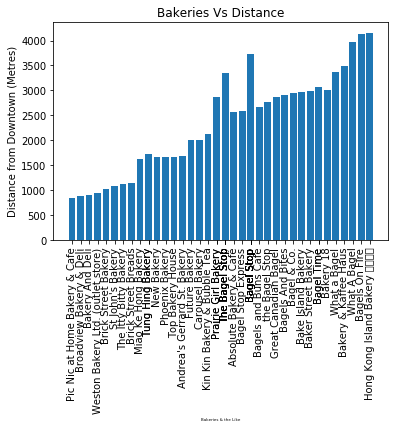

Average distance between bakeries and Downtown is 2434 metres


In [18]:
# find distance breakdown of bakeries and substitutes
distance_df=bakeries_df[['name','categories','distance','latitude','longitude']].sort_values('distance')

def plot_bar_x():
    
    index = np.arange(len(distance_df.name))
    plt.bar(distance_df.name, distance_df.distance)
    plt.xlabel('Bakeries & the Like', size=4)
    plt.ylabel('Distance from Downtown (Metres)')
    plt.xticks(distance_df.name,rotation=90)
    plt.title('Bakeries Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between bakeries and Downtown is {} metres".format(int(sum(bakeries_df['distance'])/bakeries_df.shape[0])))

In [19]:
# find sightseeings within 4km of Downtown
CLIENT_ID = 'NXBH3YZOFDJTYKSQ0CX5LOPGVW4UPTYY4FDSDWV3HBA05D3T'
CLIENT_SECRET = 'L0VQNUBLXK4A401TJ0G2TX3MIWNXZ2RCXICZATJED14B1S1M'
latitude='43.651070'
longitude='-79.347015'
VERSION='20180323'
query='hotel, museum'
radius=3000
limit=400

import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='CLIENT_ID',
client_secret='CLIENT_SECRET',
v='20180323',
ll='43.651070,-79.347015',
query='hotel, museum',
limit=400,
radius=3000)
url_venues = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,query, radius, limit)
results_venues = requests.get(url_venues).json()

# assign relevant part of JSON to venues
venues_toronto = results_venues['response']['venues']

# examine results
df_venues=json_normalize(venues_toronto)
print("There are {} venues in Toronto".format(df_venues.shape[0]))

There are 50 venues in Toronto


In [20]:
# filter dataframe
filtered_columns = ['name', 'categories'] +[col for col in df_venues.columns if col.startswith('location.')] + ['id']
df_filtered2 = df_venues.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
    except:
            address = None
            postal_code = None
            district = None
            df_filtered2.append([postal_code])
# filter the category for each row
df_filtered2['categories'] = df_filtered2.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
df_filtered2.columns = [column.split('.')[-1] for column in df_filtered2.columns]


#dataframe_filtered
venues=df_filtered2[['name','categories','address','distance','lat','lng','id']]
venues.reset_index(inplace=True)
venues.head(100)

,index,name,categories,address,distance,lat,lng,id
0,0,Hotel Pickles,None,100 booth ave,823,43.657784,-79.342712,4bd10ef0462cb71351bed907
1,1,Hotel Novotel Toronto Centre,Hotel,45 The Esplanade,2251,43.646530,-79.374250,4ad4c05bf964a520a0f520e3
2,2,Hotel 22 Division,Hotel,78 Lombard,2243,43.652210,-79.374829,4e3b8d70ae604542364bf092
3,3,Hotel Delilah,Bar,1036 Gerrard St E,2152,43.668949,-79.336825,5d2386a57dc742002349c5d1
4,4,Hotel Le Germain Fitness Room,Gym / Fitness Center,75 Bremner,2719,43.643467,-79.379099,4f55877be4b072b51d61d81c
5,5,Textile Museum of Canada,Art Museum,55 Centre Avenue,3201,43.654396,-79.386500,4ad4c05ef964a520e2f620e3
6,6,Hotel Sharky,None,NaN,3398,43.674230,-79.374506,4c0b0413a1b32d7f5d729af0
7,7,Hotel Victoria,Hotel,56 Yonge St,2484,43.648084,-79.377582,4ad4c05cf964a520b4f520e3
8,8,The Broadview Hotel,Hotel,106 Broadview Ave,921,43.659060,-79.350030,596186fd772fbc1671dff18b
9,9,One King West Hotel & Residence,Hotel,1 King St W,2495,43.649139,-79.377876,4af96fbbf964a520c01122e3


In [21]:
# rename columns
venues.rename(columns = {'lat': 'latitude','lng':'longitude'}, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [22]:
# data extracted from Foursquare venues
bakeries=pd.DataFrame(bakeries_df[['name','address','categories','distance','latitude','longitude','id']])

# concatenate both dataframe
df_venues=pd.concat([bakeries, venues],sort=True)
df_venues

,address,categories,distance,id,index,latitude,longitude,name
0,27 Trinity St,Bakery,1010,4b156a02f964a5207fac23e3,NaN,43.650574,-79.359539,Brick Street Bakery
1,161 Bay St.,Bagel Shop,2639,4d3872479784a0931e57e0e8,NaN,43.646184,-79.379077,The Bagel Stop
2,Ernst & Young Tower,Bagel Shop,2724,4d36edee10248cfa02d889cf,NaN,43.647931,-79.380564,Bagel Stop
3,20 Bay St,Bagel Shop,2670,4b910b08f964a5208fa033e3,NaN,43.641619,-79.377486,The Bagel Stop
4,NaN,Deli / Bodega,907,522f966011d221423d1d71c8,NaN,43.659127,-79.348743,Bakery And Deli
5,199 Bay St (Commerce Court),Bagel Shop,2603,52e11a21498e7356498a1d7d,NaN,43.648324,-79.379110,Bagel Stop
6,2018 Queen Street East,None,2589,4bb664ff2ea19521439aab2f,NaN,43.664621,-79.320873,Bagel Stop Express
7,130 Spadina Ave,Breakfast Spot,3960,4f7dd9a6e4b09d309a47f7fe,NaN,43.647349,-79.395912,What A Bagel
8,415 Yonge Street,Breakfast Spot,2987,4b7c0070f964a520e3772fe3,NaN,43.659642,-79.382171,Bagel Time
9,121 King Street,Bagel Shop,2824,550c4713498e1e886da1d169,NaN,43.647820,-79.381788,Bagel Stop


In [23]:
venues_map = folium.Map(location=[43.651070,-79.347015], zoom_start=13)


folium.features.CircleMarker(
    [43.651070,-79.347015],
    radius=5,
    popup='Toronto',
    fill_opacity = 0.6
).add_to(venues_map)

# add markers to represent bakeries and substitutes, and other venues
for lat,lng,name in zip(df_venues['latitude'],df_venues['longitude'],df_venues['name']):
    label = folium.Popup(str(name), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill = True,
        fill_opacity=0.6,
        parse_html=False
    ).add_to(venues_map)

# display map
venues_map

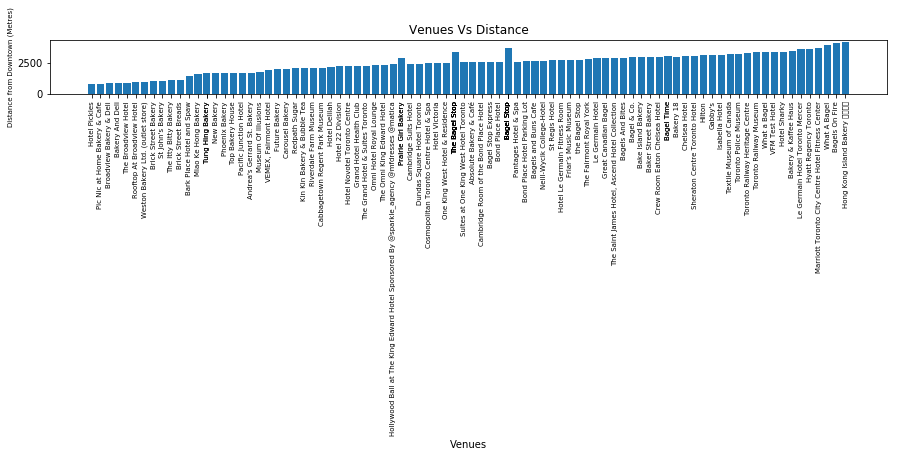

In [40]:
# find dispersion of sightseeings
distance_venues=df_venues.sort_values('distance')

def plot_bar_venue():
    index = np.arange(len(distance_venues.name))
    fig = plt.figure(figsize=(15,1))
    plt.bar(distance_venues.name, distance_venues.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from Downtown (Metres)', size=7)
    plt.xticks(distance_venues.name,rotation=90, size=7)
    plt.title('Venues Vs Distance')
    plt.show()
plot_bar_venue()

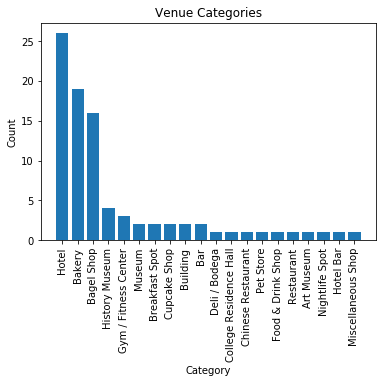

In [41]:
# find how frequently a category appears
frequency=df_venues['categories'].value_counts()
frequency=pd.DataFrame(frequency).reset_index()
frequency.columns=['Category','Count']
frequency

def plot_bar_categ():
    
    index = np.arange(len(frequency.Category))
    plt.bar(frequency.Category, frequency.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(frequency.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

In [42]:
# clustering
# set number of clusters
k=4
toronto_clustering2 = df_venues.drop(['name','id','categories','address','index'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_venues.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
fin=df_venues.groupby(['Cluster Labels']).mean()

lati=sum(fin.latitude)/len(fin.latitude)
longi=sum(fin.longitude)/len(fin.longitude)

# take midpoint of top ten closest
venues_lan=sum(df_venues.latitude)/len(df_venues.latitude)
venues_lng=sum(df_venues.longitude)/len(df_venues.longitude)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of a new bakery:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of a new bakery:43.65619737477344,-79.37023189446444


## Results

My bakery location is pointed at 43.65619737477344,-79.37023189446444.

Located at exact junction of Shuter St and Sherbourne St which is quite central location, close to famous venues, such as the Old City Hall, CF Eaton Centre, Ryerson University and Grand Hotel.

My predicted location is in the downtown area as expected due to the sightseeings and hotels where people tend to gravitate/gather.



In [48]:
# generate map of Toronto
my_bakery = folium.Map(location=[43.651070,-79.347015], zoom_start=13) 


# add red circle marker to represent the my bakery location
folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='red',
    popup='My Bakery',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_bakery)

# add other bakeries as blue circle markers
for lat, lng, label in zip(bakeries_df.latitude, bakeries_df.longitude, bakeries_df.name):
    label = folium.Popup(str(name), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_bakery)
    
    
# add other venues as green circle markers
for lat, lng, label in zip(venues.latitude, venues.longitude, venues.name):
    label = folium.Popup(str(name), parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(my_bakery)


# display map
my_bakery

## Discussion 

The maps and tables above give an idea why the predicted one is pointed/clustered on the given spot.

KMeans shows the most common place for crowded and tourist venues, such as hotels and museums.At the same time this place is close to the downtown. Nevertheless some data is missing.There are venues which are not registered by Foursquare.


## Conclusion

Kmeans as well as logic is in favour to places near to the centre because they generate more interest and attract more passers-by and potential clients in their lunch breaks, on their way to home, on their way to attractions or on their holiday. Moreover, the place is not bustling with other bakeries so that competition is thought to be a little less of an issue.

Future Expectation:

More data to analyze would add more confidence to the results we obtained in this project.

Research on bakery reviews, their price range and specialties would be helpful in the future.